In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Xf5VOkQi3NhfkldUYYHG")
project = rf.workspace("pallets-yfojl").project("pallets-segmentation")
version = project.version(1)
dataset = version.download("png-mask-semantic")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pallets-segmentation-1 in png-mask-semantic:: 100%|██████████| 2750/2750 [00:00<00:00, 6418.00it/s]


In [2]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import cv2
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

In [4]:
Image_h = 640
Image_w = 640
classes = 2
batch_size = 8
Epochs = 50

train = "/content/Pallets-segmentation-1/train"
val = "/content/Pallets-segmentation-1/valid"
test = "/content/Pallets-segmentation-1/test"

class DataGenerator(Sequence):
    def __init__(self, folder_path, batch_size, Image_h, Image_w):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.Image_h = Image_h
        self.Image_w = Image_w
        self.files = [f for f in sorted(os.listdir(folder_path)) if f.endswith(".jpg")]

    def __len__(self):
        return int(np.ceil(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []

        for file in batch_files:
            image_path = os.path.join(self.folder_path, file)
            mask_path = os.path.join(self.folder_path, file.replace(".jpg", "_mask.png"))

            if os.path.exists(mask_path):
                img = load_img(image_path, target_size=(self.Image_h, self.Image_w))
                img = img_to_array(img) / 255.0

                mask = load_img(mask_path, target_size=(self.Image_h, self.Image_w), color_mode="grayscale")
                mask = (img_to_array(mask) > 0).astype(np.uint8)

                images.append(img)
                masks.append(mask)

        return np.array(images), np.array(masks)

train_gen = DataGenerator(train, batch_size, Image_h, Image_w)
val_gen = DataGenerator(val, batch_size, Image_h, Image_w)

def unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(classes, (1, 1), activation='softmax')(c7)

    return Model(inputs, outputs)

model = unet((Image_h, Image_w, 3))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),ModelCheckpoint('best_model.keras', save_best_only=True)]

history = model.fit(train_gen,validation_data=val_gen,epochs=Epochs,callbacks=callbacks)

model.save('semantic_segmentation_model.keras')

print("Model training and saving complete!")


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 313ms/step - accuracy: 0.7223 - loss: 0.5840 - val_accuracy: 0.6956 - val_loss: 0.5219
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.7690 - loss: 0.4972 - val_accuracy: 0.8494 - val_loss: 0.4221
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 241ms/step - accuracy: 0.8093 - loss: 0.4170 - val_accuracy: 0.8492 - val_loss: 0.4016
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.8388 - loss: 0.3789 - val_accuracy: 0.8780 - val_loss: 0.3860
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.8789 - loss: 0.3624 - val_accuracy: 0.9184 - val_loss: 0.2623
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.8984 - loss: 0.2996 - val_accuracy: 0.9253 - val_loss: 0.2425
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 239ms/step - accuracy: 0.9078 - loss: 0.2858 - val_accuracy: 0.9129 - val_loss: 0.2573
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 239ms/step - accuracy: 0.9040 - loss: 0

In [8]:
model = load_model('/content/best_model.keras')

test_folder = "/content/Pallets-segmentation-1/test"

Image_h, Image_w = 640, 640

def preprocess_image(image_path, target_size=(Image_h, Image_w)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpg') and '_mask.png' not in f]

output_folder = "/content/test_predictions"
os.makedirs(output_folder, exist_ok=True)

for image_name in test_images:
    image_path = os.path.join(test_folder, image_name)
    image = preprocess_image(image_path)


    predicted_mask = model.predict(image)[0]

    print(f"Raw predicted_mask shape: {predicted_mask.shape}, dtype: {predicted_mask.dtype}")

    if predicted_mask.shape[-1] == 2:
        predicted_mask = predicted_mask[..., 1]

    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    predicted_mask = predicted_mask * 255

    print(f"Processed predicted_mask shape: {predicted_mask.shape}, dtype: {predicted_mask.dtype}, unique values: {np.unique(predicted_mask)}")

    output_path = os.path.join(output_folder, image_name.replace('.jpg', '_predicted_mask.png'))
    cv2.imwrite(output_path, predicted_mask)

    print(f"Saved predicted mask for {image_name} to {output_path}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Raw predicted_mask shape: (640, 640, 2), dtype: float32
Processed predicted_mask shape: (640, 640), dtype: uint8, unique values: [  0 255]
Saved predicted mask for 1579163485692-24_jpg.rf.5b72590caf4b1949f58361222d95cd3f.jpg to /content/test_predictions/1579163485692-24_jpg.rf.5b72590caf4b1949f58361222d95cd3f_predicted_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Raw predicted_mask shape: (640, 640, 2), dtype: float32
Processed predicted_mask shape: (640, 640), dtype: uint8, unique values: [  0 255]
Saved predicted mask for 514294926-1294_jpg.rf.3dc0a1982d8a33749f22e1e214be7f5e.jpg to /content/test_predictions/514294926-1294_jpg.rf.3dc0a1982d8a33749f22e1e214be7f5e_predicted_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Raw predicted_mask shape: (640, 640, 2), dtype: float32
Processed predicted_mask shape: (640, 640), dtype: uint8, unique values: [  0 255]
Saved predicted mask for 1574680571-851149_jpg.rf.2c9713402672bb6063f2f6545d545ff5.jpg to 

In [10]:
iou_scores = []

for image_name in test_images:
    true_mask_path = os.path.join(test_folder, image_name.replace('.jpg', '_mask.png'))
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = (true_mask > 127).astype(np.uint8)

    image_path = os.path.join(test_folder, image_name)
    image = preprocess_image(image_path)
    pred_mask = model.predict(image)[0]

    if pred_mask.shape[-1] == 2:
        pred_mask = pred_mask[..., 1]

    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    true_mask_flat = true_mask.flatten()
    pred_mask_flat = pred_mask.flatten()

    iou = jaccard_score(true_mask_flat, pred_mask_flat, average='binary')
    iou_scores.append(iou)

    print(f"IoU for {image_name}: {iou}")

mean_iou = sum(iou_scores) / len(iou_scores)
print(f"Mean IoU: {mean_iou}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
IoU for 1579163485692-24_jpg.rf.5b72590caf4b1949f58361222d95cd3f.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
IoU for 514294926-1294_jpg.rf.3dc0a1982d8a33749f22e1e214be7f5e.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
IoU for 1574680571-851149_jpg.rf.2c9713402672bb6063f2f6545d545ff5.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
IoU for 1583416443-0684996_jpg.rf.1356ec3beedb0cd82ac90c6e53765f63.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
IoU for 1583417331-5713766_jpg.rf.ba59f5de79997827a2f8f9e718a0d287.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
IoU for 1564563259-1441019_jpg.rf.34408d77ba1ae76faf926d0aae035206.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
IoU for 1579165706-9628217_jpg.rf.cae34fa1d7f9b53abfccbf0d1aee20db.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
IoU for 1576593141-0099733_jpg.rf.3b235561ec694172fc4705bf72d32d41.jpg: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
IoU for 1579165612633-66_jpg.rf.3f2824a0850bef982edd750e2

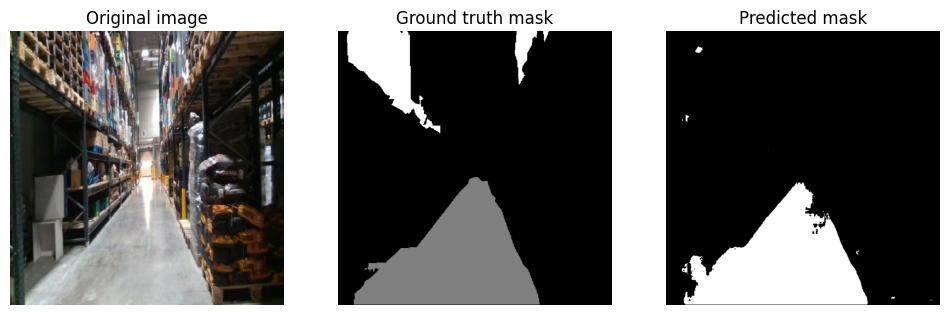

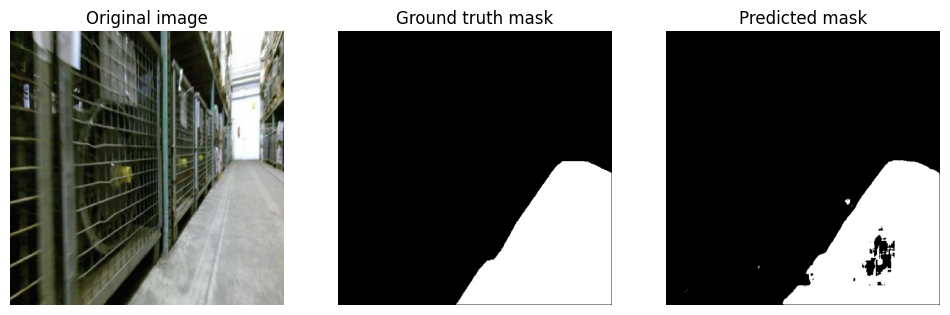

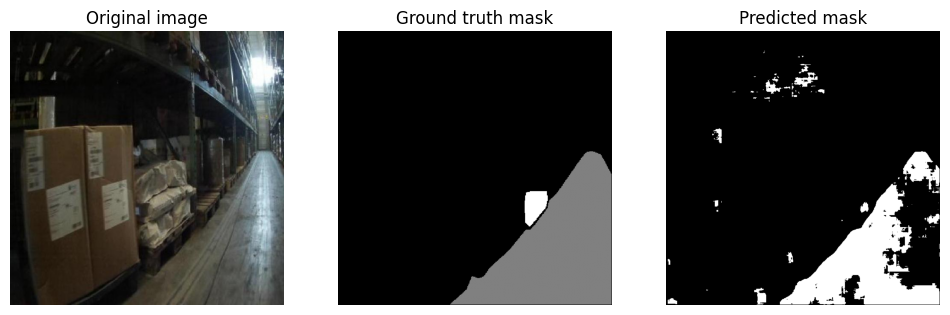

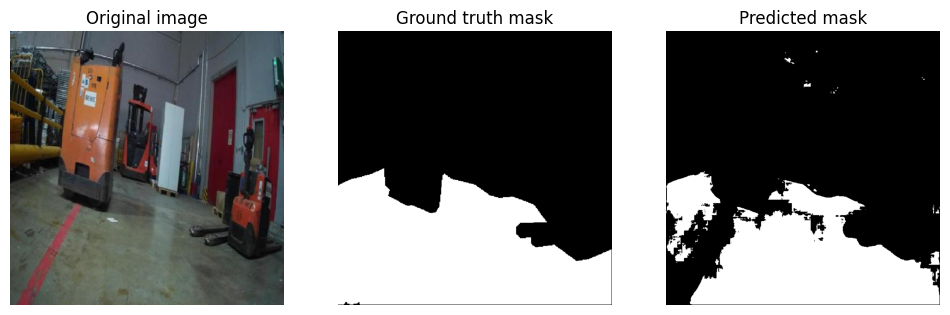

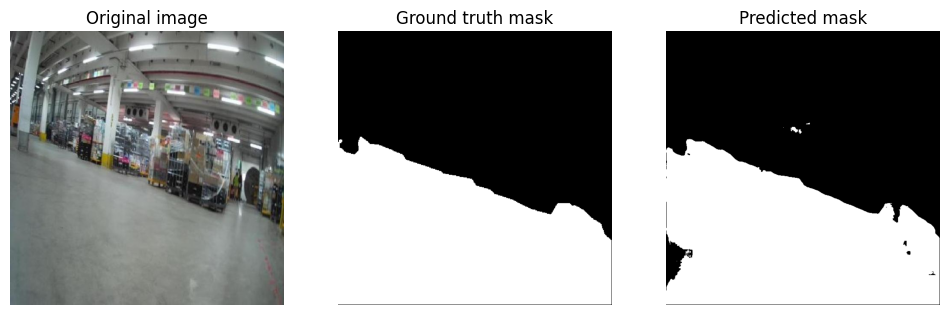

In [11]:
for i, image_name in enumerate(test_images[:5]):
    image_path = os.path.join(test_folder, image_name)
    image = cv2.imread(image_path)

    mask_path = os.path.join(test_folder, image_name.replace('.jpg', '_mask.png'))
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    pred_mask_path = os.path.join(output_folder, image_name.replace('.jpg', '_predicted_mask.png'))
    pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted mask")
    plt.axis('off')

    plt.show()


In [12]:
import shutil

s_f = '/content/test_predictions'


d_f = '/content/drive/My Drive/test_predictions'

shutil.copytree(s_f, d_f)
print(f"Folder copied to {d_f}")


Folder copied to /content/drive/My Drive/test_predictions


In [13]:
i = '/content/Pallets-segmentation-1/test'
j = '/content/drive/My Drive/test'
shutil.copytree(i, j)
print(f"Folder copied to {j}")

Folder copied to /content/drive/My Drive/test
